In [1]:
import torch
import torchvision
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torch import nn
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
import pandas as pd

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
torch.manual_seed(42)
device = 'cuda'

Split the dataset into train, validation, and test

In [3]:
transform = transforms.Compose([
    transforms.Resize([162, 162]),
    transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.ImageFolder('data', transform=transform)
artists = dataset.classes

TRAIN_SIZE = int(0.7 * len(dataset))
VAL_SIZE = int(0.15 * len(dataset))
TEST_SIZE = len(dataset) - TRAIN_SIZE - VAL_SIZE

train_dataset, val_dataset, test_dataset = random_split(dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

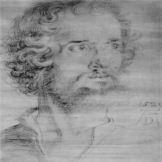

In [5]:
transforms.ToPILImage()(dataset[0][0])

In [6]:
print(dataset[0][1])
print(artists[dataset[0][1]])

0
Albrecht_Durer


Network architecture

In [7]:
LABELS = 50

class ModelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3)
        self.classifier = nn.Linear(in_features=6 * 6 * 40, out_features=LABELS)

    # Returns logits    
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool3(x)
        x = nn.Flatten()(x)
        x = self.classifier(x)
        return x

model = ModelCNN().to(device)

In [20]:
def show_batch(batch, rows, cols):
    figure = plt.figure(figsize=(12, 12))
    for i in range(rows * cols):
        img = batch[0][i]
        label = batch[1][i]
        figure.add_subplot(rows, cols, i + 1)
        plt.axis("off")
        plt.title(artists[label.item()])
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

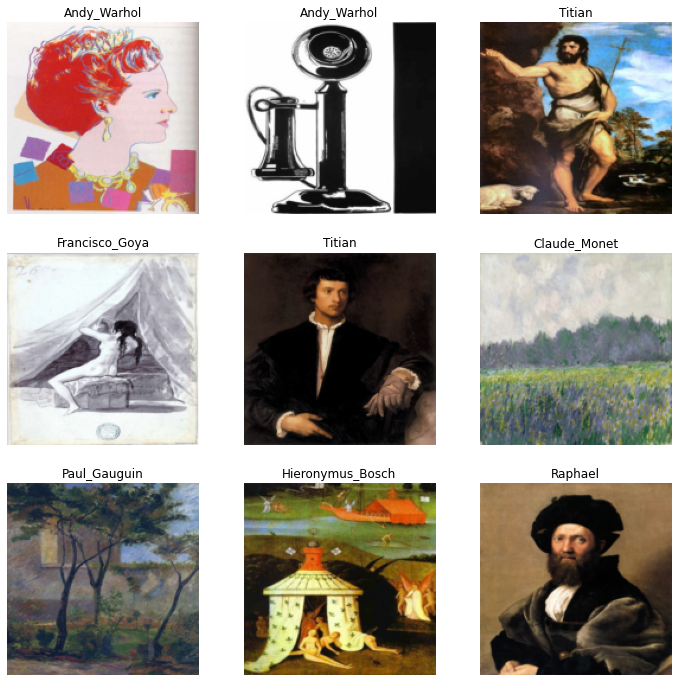

In [21]:
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=9, shuffle=True)

show_batch(next(iter(train_loader)), 3, 3)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
def get_logits(batch):
    imgs = batch[0].to(device)
    with torch.no_grad():
        logits = model(imgs)
    return logits

In [12]:
BATCH_SEG = 100

train_losses = []
val_losses = []

for epoch in range(15):
    print(f'Epoch {epoch}')
    running_loss = 0.0
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()
        if i % BATCH_SEG == BATCH_SEG - 1:
            print(f'Running loss: {running_loss / BATCH_SEG:.3f}')
            running_loss = 0
    train_loss /= len(train_loader)
    print(f'Training loss: {train_loss:.3f}')

    val_loss = 0.0
    for data in val_loader:
        logits = get_logits(data)
        labels = data[1].to(device)
        with torch.no_grad():
            loss = criterion(logits, labels)
        val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Validation loss: {val_loss:.3f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print('Done')

Epoch 0
Running loss: 3.791
Running loss: 3.543
Running loss: 3.573
Running loss: 3.487
Running loss: 3.446
Running loss: 3.384
Training loss: 3.526
Validation loss: 3.366
Epoch 1
Running loss: 3.337
Running loss: 3.290
Running loss: 3.281
Running loss: 3.210
Running loss: 3.242
Running loss: 3.275
Training loss: 3.264
Validation loss: 3.246
Epoch 2
Running loss: 3.198
Running loss: 3.133
Running loss: 3.111
Running loss: 3.171
Running loss: 3.111
Running loss: 3.102
Training loss: 3.136
Validation loss: 3.129
Epoch 3
Running loss: 3.021
Running loss: 3.073
Running loss: 3.026
Running loss: 3.060
Running loss: 2.940
Running loss: 3.006
Training loss: 3.015
Validation loss: 3.000
Epoch 4
Running loss: 2.952
Running loss: 2.895
Running loss: 2.894
Running loss: 2.898
Running loss: 2.813
Running loss: 2.874
Training loss: 2.890
Validation loss: 2.899
Epoch 5
Running loss: 2.814
Running loss: 2.817
Running loss: 2.728
Running loss: 2.748
Running loss: 2.781
Running loss: 2.755
Training los

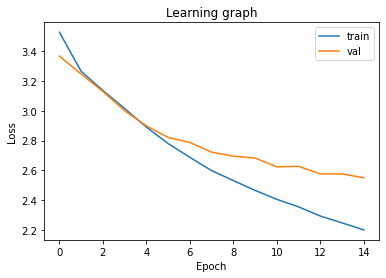

In [13]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='train')
ax.plot(val_losses, label='val')
ax.legend()
plt.title('Learning graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
model.eval()

heatmap = np.zeros((LABELS, LABELS))
test_loader = DataLoader(test_dataset, batch_size=9, shuffle=True)

for data in test_loader:
    logits = get_logits(data)
    labels = data[1].to(device)
    preds = logits.argmax(axis=1)
    for i in range(labels.shape[0]):
        heatmap[labels[i].item()][preds[i].item()] += 1

In [15]:
print(f'Average precision: {np.trace(heatmap) / np.sum(heatmap)}')

Average precision: 0.30701754385964913


In [16]:
def print_artist_data(arr, field_name):
    df = pd.DataFrame({'name': artists, field_name : arr})
    print(df.round(2))

In [17]:
print('Recall by artists:')
recall = np.diag(heatmap) / np.sum(heatmap, axis=1)
print_artist_data(recall, 'recall')

Recall by artists:
                         name  recall
0              Albrecht_Durer    0.66
1               Alfred_Sisley    0.55
2           Amedeo_Modigliani    0.43
3               Andrei_Rublev    0.15
4                 Andy_Warhol    0.03
5            Camille_Pissarro    0.08
6                  Caravaggio    0.22
7                Claude_Monet    0.08
8                Diego_Rivera    0.20
9             Diego_Velazquez    0.00
10                Edgar_Degas    0.71
11              Edouard_Manet    0.06
12               Edvard_Munch    0.00
13                   El_Greco    0.36
14           Eugene_Delacroix    0.00
15             Francisco_Goya    0.32
16                Frida_Kahlo    0.54
17             Georges_Seurat    0.09
18          Giotto_di_Bondone    0.56
19               Gustav_Klimt    0.12
20            Gustave_Courbet    0.00
21              Henri_Matisse    0.23
22             Henri_Rousseau    0.25
23  Henri_de_Toulouse-Lautrec    0.00
24           Hieronymus_Bosch  

<ipython-input-17-edc8288dde8c>:2: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(heatmap) / np.sum(heatmap, axis=1)


In [18]:
print('Precision by artists:')
prec = np.diag(heatmap) / np.sum(heatmap, axis=0)
print_artist_data(prec, 'precision')

Precision by artists:
                         name  precision
0              Albrecht_Durer       0.46
1               Alfred_Sisley       0.45
2           Amedeo_Modigliani       0.46
3               Andrei_Rublev       0.25
4                 Andy_Warhol       1.00
5            Camille_Pissarro       0.33
6                  Caravaggio       0.25
7                Claude_Monet       1.00
8                Diego_Rivera       0.80
9             Diego_Velazquez        NaN
10                Edgar_Degas       0.33
11              Edouard_Manet       1.00
12               Edvard_Munch        NaN
13                   El_Greco       0.09
14           Eugene_Delacroix        NaN
15             Francisco_Goya       0.24
16                Frida_Kahlo       0.35
17             Georges_Seurat       1.00
18          Giotto_di_Bondone       0.32
19               Gustav_Klimt       0.12
20            Gustave_Courbet        NaN
21              Henri_Matisse       0.17
22             Henri_Rousseau      

<ipython-input-18-4e58d5b47cb1>:2: RuntimeWarning: invalid value encountered in divide
  prec = np.diag(heatmap) / np.sum(heatmap, axis=0)


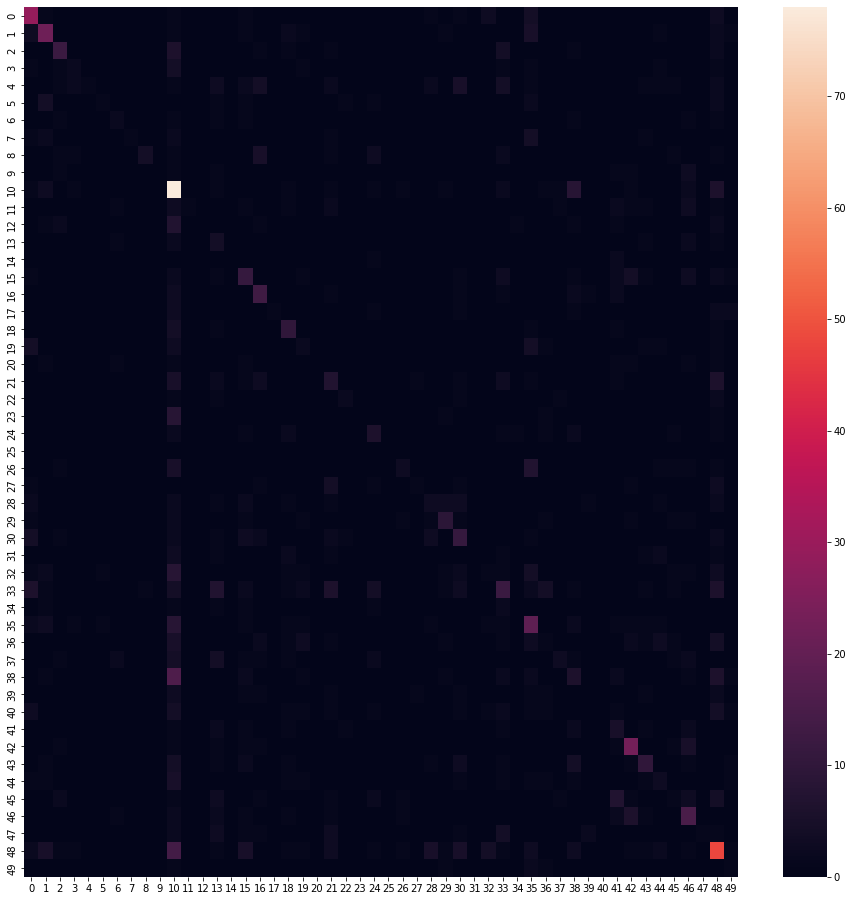

In [19]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(heatmap, ax=ax)
plt.show()